In [2]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
from comparers import ModelComparer
import pandas as pd
import diro2c
from data_generation.helper import prepare_df
from data_generation.neighborhood_generation import neighbor_generator
from enums.diff_classifier_method_type import diff_classifier_method_type
from mlxtend.plotting import plot_decision_regions
from sklearn.tree import plot_tree
import rule_extractor
shap.initjs()
%matplotlib inline
task_name = '08'

In [3]:
with open(task_name + '.dataset', 'rb') as f:
    X, y, feature_names = pickle.load(f)
with open(task_name + '.models', 'rb') as f:
    comparer = pickle.load(f)

# Explain using Interpretability Methods

Prepare dataset for diro2c

In [6]:
idx_explain = 0

In [7]:
feature1 = []
feature2 = []
for x in X:
    feature1.append(x[0])
    feature2.append(x[1])

feature1 = np.asarray(feature1)
feature2 = np.asarray(feature2)

y = y.astype(str)

d = {'y': y, 'feature_1': feature1, 'feature_2': feature2}

df = pd.DataFrame(d)

dataset = prepare_df(df, 'test', 'y')

## Binary difference explanations

In [8]:
diff_classifiers_info = diro2c.recognize_diff(idx_explain, X, dataset, comparer.clf_a, comparer.clf_b,
                                              diff_classifier_method_type.binary_diff_classifier,
                                              data_generation_function=neighbor_generator.get_modified_genetic_neighborhood)

In [9]:
dc_info = diff_classifiers_info['binary_diff_classifer']
dc_full = dc_info['dc_full']
dc_test = dc_info['dc_test']
evaluation_info = dc_info['evaluation_info']

X_diff = evaluation_info['X']
y_diff = evaluation_info['y']

print(np.unique(y_diff, return_counts=True))

(array([0, 1]), array([451, 294]))


Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.


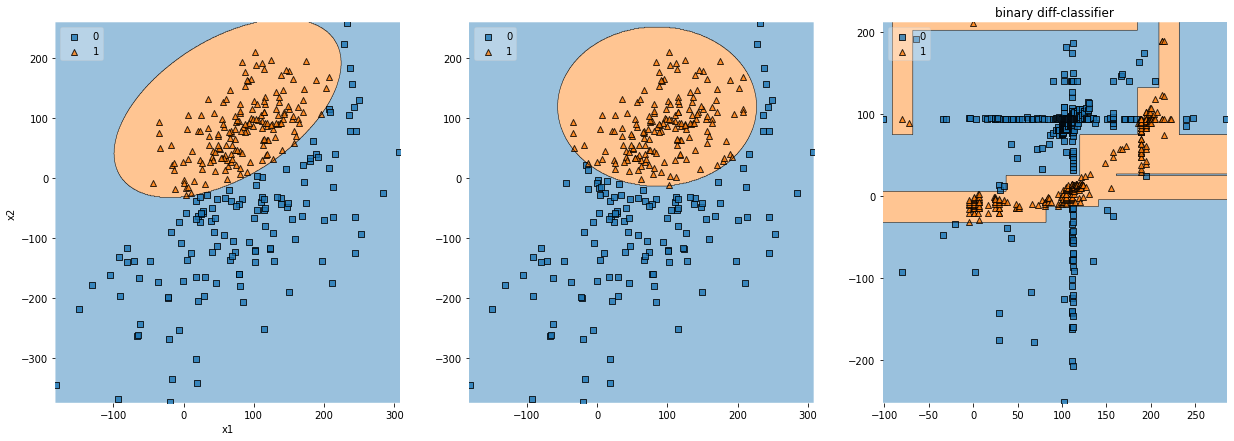

In [10]:
y_pred_a = comparer.clf_a.predict(X)
y_pred_b = comparer.clf_b.predict(X)

fig, ax = plt.subplots(1, 3, figsize=(21, 7))

fig = plot_decision_regions(X=X, y=y_pred_a.astype(
    np.int64), clf=comparer.clf_a, ax=ax[0], legend=2)
ax[0].set_xlabel(feature_names[0])
ax[0].set_ylabel(feature_names[1])
plt.title('blackbox 1')

fig = plot_decision_regions(X=X, y=y_pred_b.astype(
    np.int64), clf=comparer.clf_b, ax=ax[1], legend=2)
ax[0].set_xlabel(feature_names[0])
ax[0].set_ylabel(feature_names[1])
plt.title('blackbox 2')

fig = plot_decision_regions(X=X_diff, y=y_diff.astype(
    np.integer), clf=dc_full, ax=ax[2], legend=2)
ax[0].set_xlabel(feature_names[0])
ax[0].set_ylabel(feature_names[1])
plt.title('binary diff-classifier')

plt.show()

We see, that diro2c starts in the center of confusion class $(1, 1)$, and goes in all directions outwards to find the rim, where both classifiers predict differently. It evens detects areas not present in the dataset. It's not a 100% correct, because for the are on the right there should have been no difference detected. But as it is a local explanation for the instance selected, we might as well start with a different instance.

[Text(512.3611111111111, 849.375, 'x2 <= 74.5\ngini = 0.478\nsamples = 745\nvalue = [451, 294]\nclass = no_diff'),
 Text(284.16666666666663, 736.125, 'x2 <= -31.5\ngini = 0.385\nsamples = 273\nvalue = [71, 202]\nclass = diff'),
 Text(249.7222222222222, 622.875, 'gini = 0.0\nsamples = 42\nvalue = [42, 0]\nclass = no_diff'),
 Text(318.6111111111111, 622.875, 'x2 <= 24.0\ngini = 0.22\nsamples = 231\nvalue = [29, 202]\nclass = diff'),
 Text(223.88888888888889, 509.625, 'x1 <= 140.5\ngini = 0.094\nsamples = 183\nvalue = [9, 174]\nclass = diff'),
 Text(137.77777777777777, 396.375, 'x2 <= -13.0\ngini = 0.075\nsamples = 180\nvalue = [7, 173]\nclass = diff'),
 Text(68.88888888888889, 283.125, 'x1 <= 81.0\ngini = 0.245\nsamples = 28\nvalue = [4, 24]\nclass = diff'),
 Text(34.44444444444444, 169.875, 'gini = 0.0\nsamples = 24\nvalue = [0, 24]\nclass = diff'),
 Text(103.33333333333333, 169.875, 'gini = 0.0\nsamples = 4\nvalue = [4, 0]\nclass = no_diff'),
 Text(206.66666666666666, 283.125, 'x1 <= 3

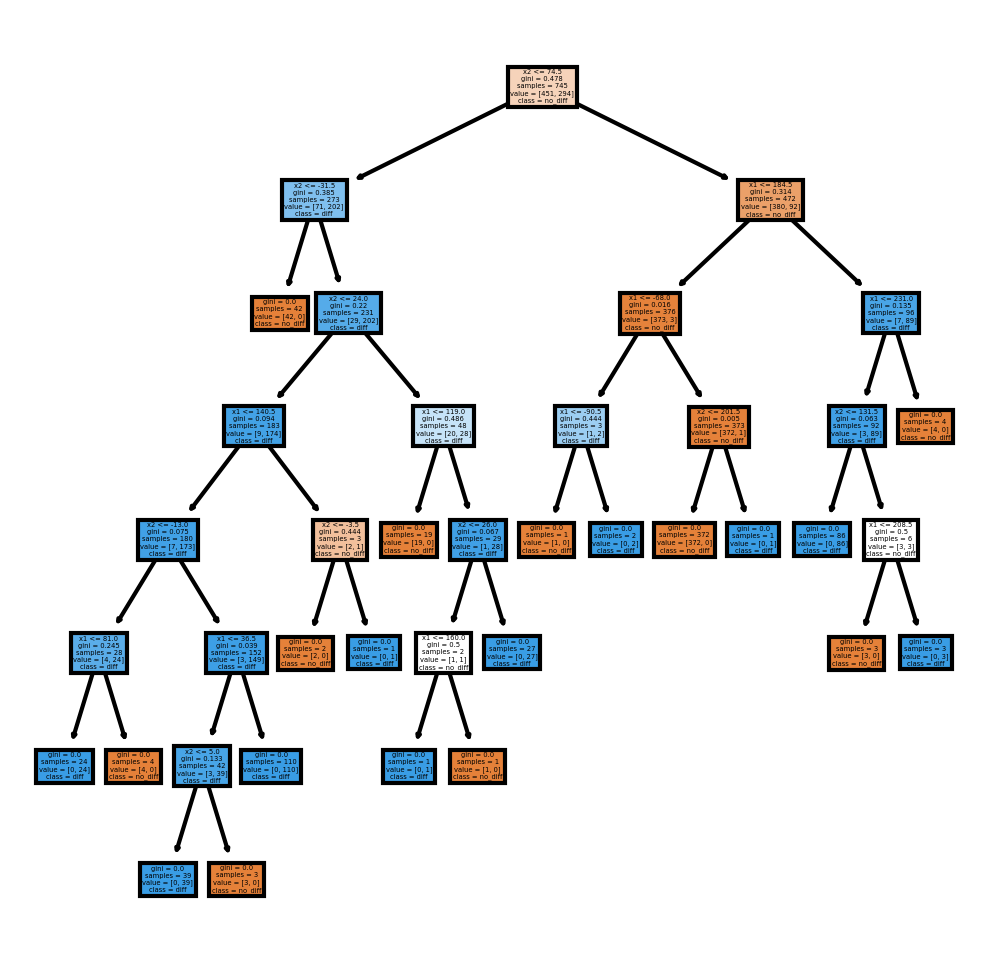

In [11]:
cn = ['no_diff', 'diff']
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), dpi=300)
plot_tree(dc_full,
               feature_names=feature_names,
               class_names=cn,
               filled=True)

In [12]:
rule_extractor.print_rules_for_binary(
    dc_full, dataset['columns_for_decision_rules'], ['no_diff', 'diff'], 'diff')

{'diff': '{feature_2 <= 74.5, feature_2 > -31.5, feature_2 <= 24.0, feature_1 <= 140.5, feature_2 <= -13.0, feature_1 <= 81.0}'}
{'diff': '{feature_2 <= 74.5, feature_2 > -31.5, feature_2 <= 24.0, feature_1 <= 140.5, feature_2 > -13.0, feature_1 <= 36.5, feature_2 <= 5.0}'}
{'diff': '{feature_2 <= 74.5, feature_2 > -31.5, feature_2 <= 24.0, feature_1 <= 140.5, feature_2 > -13.0, feature_1 > 36.5}'}
{'diff': '{feature_2 <= 74.5, feature_2 > -31.5, feature_2 <= 24.0, feature_1 > 140.5, feature_2 > -3.5}'}
{'diff': '{feature_2 <= 74.5, feature_2 > -31.5, feature_2 > 24.0, feature_1 > 119.0, feature_2 <= 26.0, feature_1 <= 160.0}'}
{'diff': '{feature_2 <= 74.5, feature_2 > -31.5, feature_2 > 24.0, feature_1 > 119.0, feature_2 > 26.0}'}
{'diff': '{feature_2 > 74.5, feature_1 <= 184.5, feature_1 <= -68.0, feature_1 > -90.5}'}
{'diff': '{feature_2 > 74.5, feature_1 <= 184.5, feature_1 > -68.0, feature_2 > 201.5}'}
{'diff': '{feature_2 > 74.5, feature_1 > 184.5, feature_1 <= 231.0, feature_2 <

## Multiclass difference explanations

In [13]:
multiclass_diff_names = ['(0, 0)', '(1, 1)', '(1, 0)', '(0, 1)']

In [15]:
diff_classifiers_info = diro2c.recognize_diff(idx_explain, X, dataset, comparer.clf_a, comparer.clf_b,
                                              diff_classifier_method_type.multiclass_diff_classifier,
                                              data_generation_function=neighbor_generator.get_modified_genetic_neighborhood)

In [16]:
dc_info = diff_classifiers_info['multiclass_diff_classifer']
dc_full = dc_info['dc_full']
dc_test = dc_info['dc_test']
evaluation_info = dc_info['evaluation_info']

X_diff = evaluation_info['X']
y_diff = evaluation_info['y']

print(np.unique(y_diff, return_counts=True))

(array([1, 2, 3, 4]), array([ 60, 398,  76, 277]))


You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


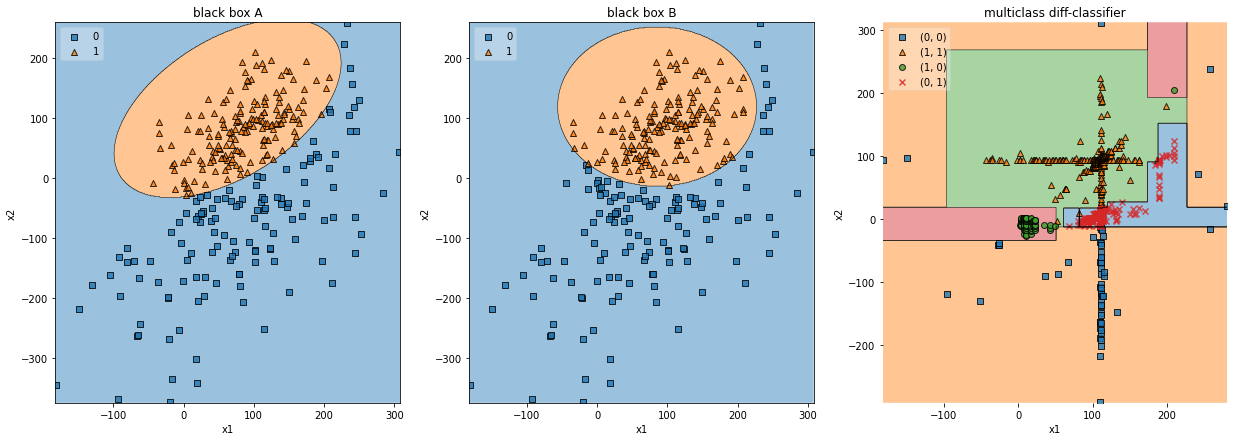

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(21, 7))

fig = plot_decision_regions(X=X, y=y_pred_a.astype(
    np.int64), clf=comparer.clf_a, ax=ax[0], legend=2, hide_spines=False)
ax[0].set_xlabel(feature_names[0])
ax[0].set_ylabel(feature_names[1])
ax[0].set_title('black box A')

fig = plot_decision_regions(X=X, y=y_pred_b.astype(
    np.int64), clf=comparer.clf_b, ax=ax[1], legend=2, hide_spines=False)
ax[1].set_xlabel(feature_names[0])
ax[1].set_ylabel(feature_names[1])
ax[1].set_title('black box B')

fig = plot_decision_regions(X=X_diff, y=y_diff.astype(
    np.int64), clf=dc_full, ax=ax[2], legend=2)
ax[2].set_xlabel(feature_names[0])
ax[2].set_ylabel(feature_names[1])
ax[2].set_title('multiclass diff-classifier')

handles, labels = ax[2].get_legend_handles_labels()
ax[2].legend(handles,
             multiclass_diff_names,
             framealpha=0.3, scatterpoints=1)

plt.show()


Here it correctly detects the two difference classes. It has missed the smaller difference class on the top left of $(1, 1)$, and it is necessary to note that the class labels are wrong, which might be just a visualization issue.

[Text(418.50000000000006, 849.375, 'x2 <= 19.5\ngini = 0.628\nsamples = 811\nvalue = [60, 398, 76, 277]\nclass = (1, 1)'),
 Text(148.8, 736.125, 'x1 <= 50.5\ngini = 0.513\nsamples = 382\nvalue = [54, 3, 75, 250]\nclass = (0, 1)'),
 Text(74.4, 622.875, 'x2 <= -32.5\ngini = 0.137\nsamples = 81\nvalue = [6, 0, 75, 0]\nclass = (1, 0)'),
 Text(37.2, 509.625, 'gini = 0.0\nsamples = 6\nvalue = [6, 0, 0, 0]\nclass = (0, 0)'),
 Text(111.60000000000001, 509.625, 'gini = 0.0\nsamples = 75\nvalue = [0, 0, 75, 0]\nclass = (1, 0)'),
 Text(223.20000000000002, 622.875, 'x2 <= -11.5\ngini = 0.285\nsamples = 301\nvalue = [48, 3, 0, 250]\nclass = (0, 1)'),
 Text(186.0, 509.625, 'gini = 0.0\nsamples = 48\nvalue = [48, 0, 0, 0]\nclass = (0, 0)'),
 Text(260.40000000000003, 509.625, 'x1 <= 60.5\ngini = 0.023\nsamples = 253\nvalue = [0, 3, 0, 250]\nclass = (0, 1)'),
 Text(223.20000000000002, 396.375, 'gini = 0.0\nsamples = 1\nvalue = [0, 1, 0, 0]\nclass = (1, 1)'),
 Text(297.6, 396.375, 'x2 <= 17.0\ngini = 0.

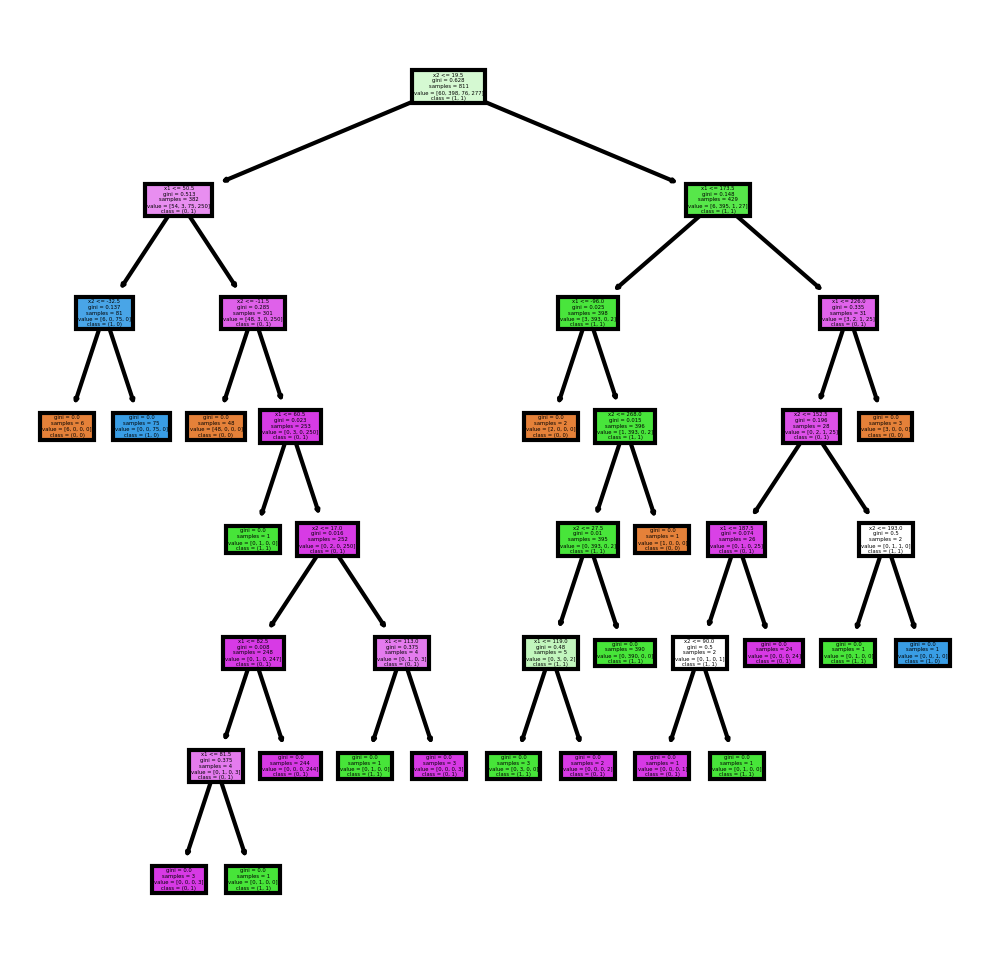

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), dpi=300)
plot_tree(dc_full,
               feature_names=feature_names,
               class_names=multiclass_diff_names,
               filled=True)